# **1. Crop the cells from image**

Read the input gridded input and crop out the cells and store into an array


***Imports***

In [ ]:
# !pip install pandas tabulate
# !pip install seaborn

# Import libraries
import cv2
import os
import sys
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from sklearn.utils import shuffle
from keras.optimizers import Adam
from skimage.filters import sobel
from keras.layers import MaxPool2D
from keras.models import Sequential
from keras.utils import to_categorical
from skimage.segmentation import watershed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab.patches import cv2_imshow

In [ ]:
# Define colours
red = (0, 0, 255)
black = (0, 0, 0)
white = (255, 255, 255)
blue = (255, 0, 0)
green = (0, 255, 0)
yellow = (0, 255, 255)
orange = (0, 165, 255)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Successfully extracted and saved 0 cell images to 'cropped_cells' folder.


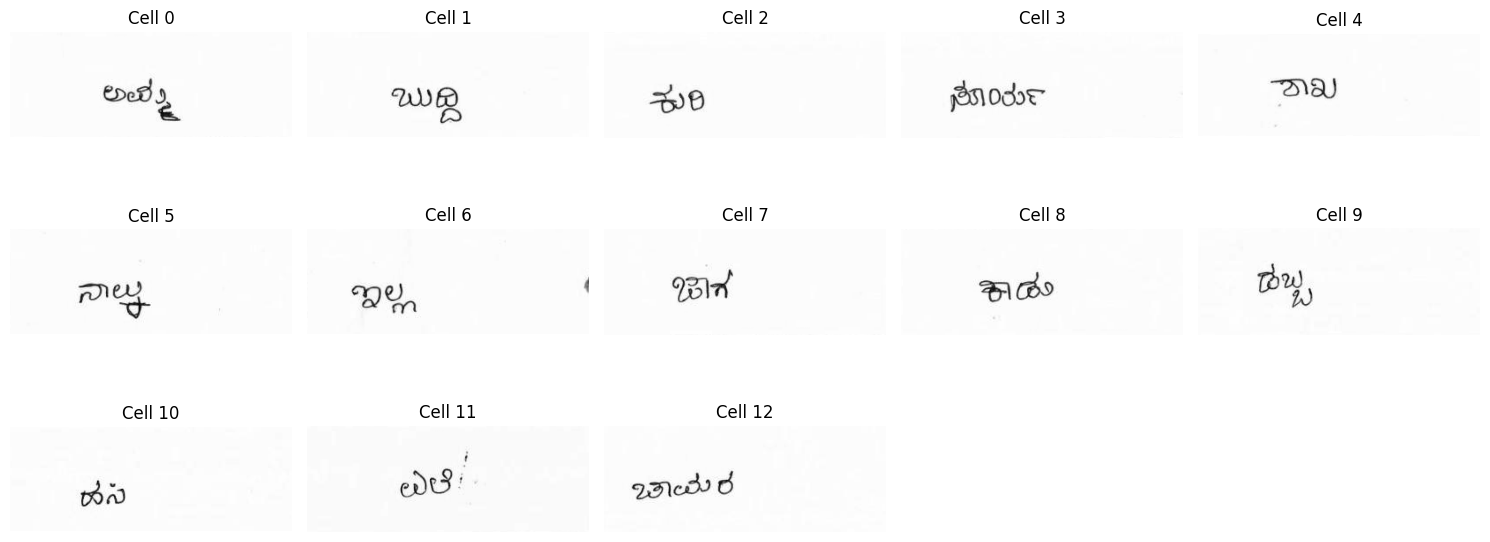

In [ ]:
# Define the folder to store cropped images
output_folder = "cropped_cells"

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Read the image
img = cv2.imread('/content/img4.jpg')  # Replace with the actual path to your image

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply denoising
# denoised = cv2.fastNlMeansDenoising(img, None, 30, 7, 21)

# Apply edge detection using Canny
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Find contours in the edge-detected image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize an empty list to store cropped images
cropped_images = []

# Define additional filters for valid cells
min_area = 1000  # Minimum area for a valid cell
max_aspect_ratio = 2.5  # Maximum aspect ratio for a valid cell
crop_offset = 10
# crop_offset = 5

# Loop through all contours and filter based on area and aspect ratio

i = 0
print(f"Successfully extracted and saved {i} cell images to '{output_folder}' folder.")

# Loop through all contours and filter based on area and aspect ratio
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / h
    # print("Cell " , i, aspect_ratio)
    if cv2.contourArea(contour) < min_area or aspect_ratio > max_aspect_ratio:
        continue

    # Crop the region of interest (ROI) from the original image
    # cropped_image = img[y+crop_offset:y+h-(crop_offset), x+crop_offset:x+w-(crop_offset)]
    cropped_image = img[y+crop_offset:y+h-(crop_offset), x+crop_offset:x+w-(crop_offset)]

    # Convert to grayscale if needed
    updated_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

    # Save the cropped image with a unique filename
    output_filename = os.path.join(output_folder, f"cell_{i}.jpg")
    cv2.imwrite(output_filename, cropped_image)
    i += 1

    # Append the cropped image to the list
    cropped_images.append(updated_image)

# Calculate number of rows and columns for displaying all images
# n_rows = int(np.ceil(len(cropped_images) ** 0.5))
# n_cols = int(np.ceil(len(cropped_images) / n_rows))

n_rows = 5
n_cols = 5

# Display all cropped images
plt.figure(figsize=(15, 10))
for i, image in enumerate(cropped_images):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Cell {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Delete the cropped images
# !rm -r cropped_cells

# ***2. Read the image and start pre-processing***

***Read the image and Resize the image to fixed dimensions***

(-0.5, 320.5, 119.5, -0.5)

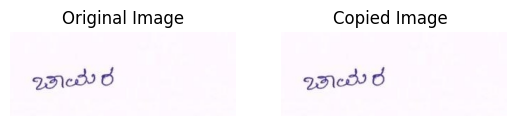

In [ ]:
################## Read Image #####################
#### Read original Image
# img = cv2.imread('abcd.png')
img = cv2.imread('/content/cropped_cells/cell_12.jpg')
# cv2_imshow(img)

# desired_size = (250,150)
# img = cv2.resize(img, desired_size)

#### Make a copy of the original image
inputCopy = img.copy()

# fg_bg = cv2.createBackgroundSubtractorMOG2()
# img = fg_bg.apply(img)

# # Ensure img is a 3-channel image (BGR)
# img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(inputCopy, cv2.COLOR_BGR2RGB))
plt.title('Copied Image ')
plt.axis('off')

**Pre-processing**

In [ ]:
################## Pre-processing #####################
print("\nPre-processing starts...")
print("1-Converting image to grayscale")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

print("2-Applying blur")
gaussian_blur = cv2.GaussianBlur(gray,(3,3),0)

print("3-Applying threshold")
_,thresh_otsu = cv2.threshold(gaussian_blur,127,255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# thresh_otsu = cv2.adaptiveThreshold(gaussian_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
# kernel = np.ones((5,5), np.uint8)
# thresh_otsu = cv2.morphologyEx(thresh_otsu, cv2.MORPH_CLOSE, kernel, iterations=2)

print("4-Applying elevation map")
elevation_map_otsu_blur = sobel(thresh_otsu)

print("5-Applying segmentation")
markers = np.zeros_like(thresh_otsu)
markers[thresh_otsu < 30] = 1
markers[thresh_otsu > 150] = 2
segmentation_otsu_blur = watershed(elevation_map_otsu_blur, markers)
segmentation_normalised = cv2.normalize(src=segmentation_otsu_blur, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
print("\nPre-processing is Done!")



Pre-processing starts...
1-Converting image to grayscale
2-Applying blur
3-Applying threshold
4-Applying elevation map
5-Applying segmentation

Pre-processing is Done!


***Show the pre-processing steps's output***

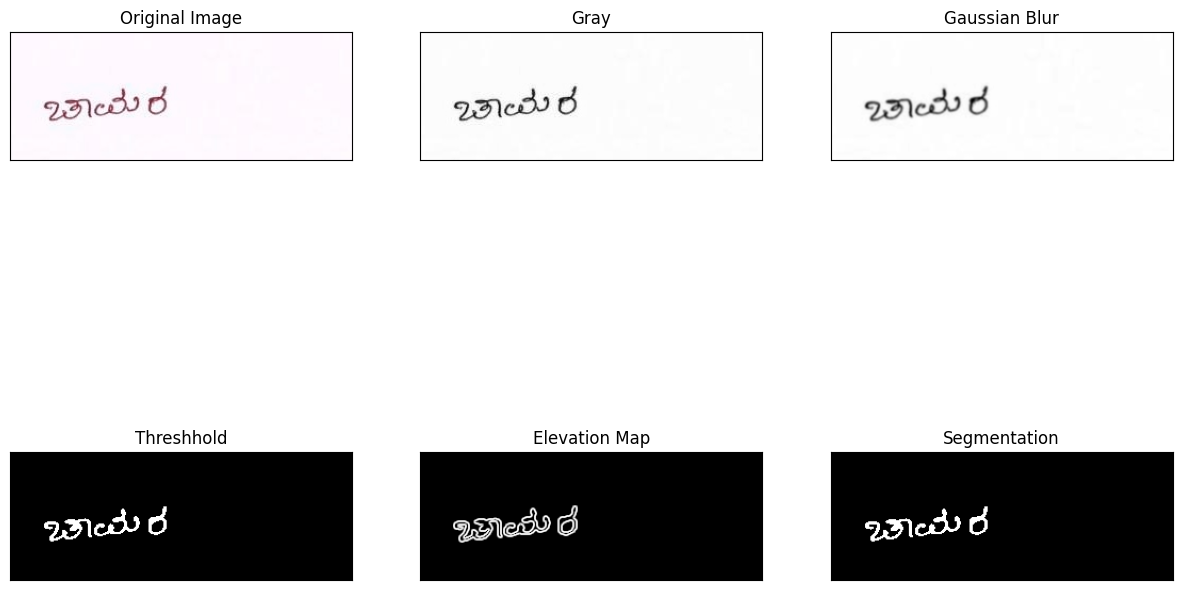

In [ ]:
### Show image processed from original to final
titles = ['Original Image', 'Gray', 'Gaussian Blur', 'Threshhold','Elevation Map', 'Segmentation']
images = [img, gray, gaussian_blur, thresh_otsu, elevation_map_otsu_blur, segmentation_otsu_blur]

inputCopy = img

plt.figure(figsize=(15, 10))

for i in np.arange(len(images)):
    plt.subplot(2,3, i + 1)
    plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

# Adjust the height between subplots to reduce the gap
# plt.subplots_adjust(hspace=-0.01)

plt.show()

# plt.subplot(1,1,1),plt.imshow(segmentation_otsu_blur,'gray')
# plt.show()

***Crop characters identified in individual cells***

# ***3. Start using Contour Detection***

In [ ]:
# Create original copies
master_img_copy = inputCopy.copy()
bb_only_img = inputCopy.copy()
cc_only_img = inputCopy.copy()

In [ ]:
################# Crop Image #####################
# print("\nCropping image starts...")
#### Find countours from thresholded image
contours, hierarchy = cv2.findContours(segmentation_normalised, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

#### Check for outer contours
contours_poly = [None] * len(contours)
boundRect = []
for i, c in enumerate(contours):
    if hierarchy[0][i][3] == -1:
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect.append(cv2.boundingRect(contours_poly[i]))


print("Original Bounding Boxes        : ", boundRect)
boundRect = sorted(boundRect)
print("Original Sorted Bounding Boxes : ", boundRect)

# Define a threshold for width and height
width_threshold = 10
height_threshold = 10

# Filter bounding boxes based on width and height
boundRect = [rect for rect in boundRect if rect[2] > width_threshold and rect[3] > height_threshold]
print("Filtered Bounding Boxes        : ", boundRect)

### Draw retangles around the letters in the copied image
for box in boundRect:
    x, y, width, height = box
    cv2.rectangle(inputCopy, (x, y), (x + width, y + height), blue , 1)
    cv2.rectangle(bb_only_img, (x, y), (x + width, y + height), blue , 1)

Original Bounding Boxes        :  [(32, 62, 45, 22), (79, 53, 43, 25), (130, 51, 17, 26)]
Original Sorted Bounding Boxes :  [(32, 62, 45, 22), (79, 53, 43, 25), (130, 51, 17, 26)]
Filtered Bounding Boxes        :  [(32, 62, 45, 22), (79, 53, 43, 25), (130, 51, 17, 26)]


In [ ]:
# Draw points along the outer boundary of filtered contours
for c in contours:
    # Draw the entire contour
    color1 = (0, 255, 0) #green
    color2 = (100,255,255)   #yellow
    cv2.drawContours(inputCopy, [c], 0, color1, 1)

    # Get points along the contour
    epsilon = 0.1 * cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, epsilon, True)

    # Draw points on the inputCopy image
    point_size = 3
     # Adjust the point size as needed
    for point in approx:
        cv2.circle(inputCopy, tuple(point[0]), point_size, color2, -1)
        cv2.circle(cc_only_img, tuple(point[0]), point_size, color2, -1)

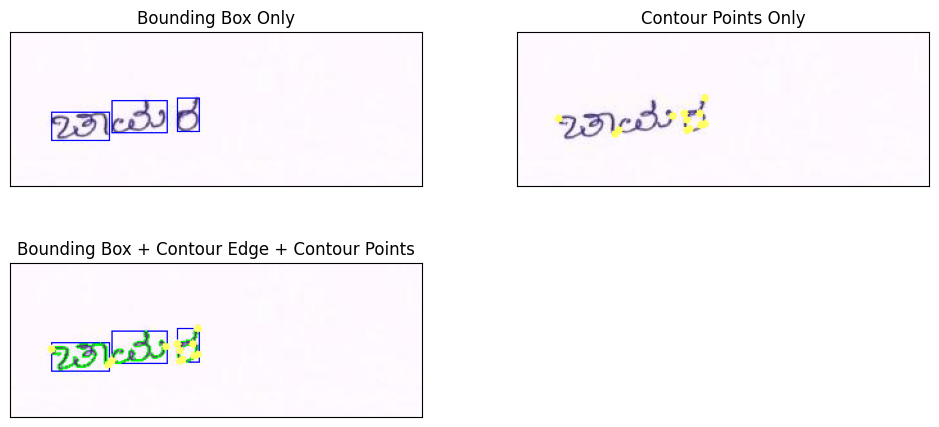

In [ ]:
### Show image processed from bb to cc
titles = ['Bounding Box Only', 'Contour Points Only','Bounding Box + Contour Edge + Contour Points']
images = [bb_only_img, cc_only_img, inputCopy]

plt.figure(figsize=(12, 5))
plt.subplots_adjust(hspace=0.5)

for i in np.arange(len(images)):
    plt.subplot(2,2, i + 1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.show()

***Display each individual cropped segment***

In [ ]:
### Crop the characteres from the image
cropped_list = []
for i in range(len(boundRect)):
    #### Offset the image so is more in the center
    dimension_offset = 5
    position_offset = 2
    x, y, w, h = boundRect[i]
    h = h+dimension_offset
    w = w+dimension_offset
    x = x-position_offset
    y = y-position_offset

    #### Crop
    croppedImg = segmentation_normalised[y:y + h, x:x + w]
    cropped_list.append(croppedImg)
    ### Show each character cropped
    print("Cropped Character: "+str(i))
    cv2_imshow( croppedImg)

print("\nCropping is Done!")

Cropped Character: 0


Cropped Character: 1


Cropped Character: 2



Cropping is Done!


# ***4. Extract Features***

***Identify top, left, right and bottom points from individual characters and draw a line based on first character's points***

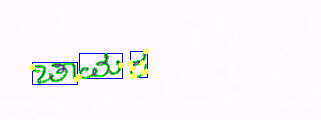

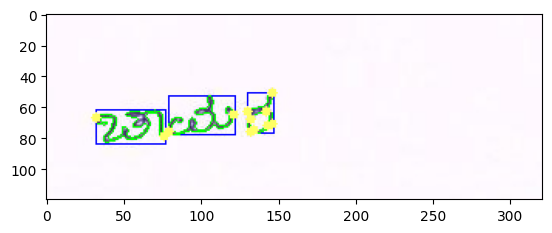

In [ ]:
plt.imshow(cv2.cvtColor(inputCopy, cv2.COLOR_BGR2RGB))
cv2_imshow(inputCopy)

3


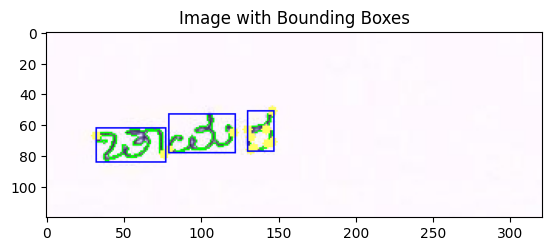

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load your image (replace 'your_image.jpg' with the actual path)
image = inputCopy

# Loop through the list of bounding boxes
print(len(boundRect))
bb_color = blue
for box in boundRect:
    x, y, width, height = box
    # Draw a rectangle on the image
    cv2.rectangle(image, (x, y), (x + width, y + height), bb_color , 1)

# Convert BGR image to RGB (OpenCV uses BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes
plt.imshow(image_rgb)
plt.title('Image with Bounding Boxes')
plt.show()


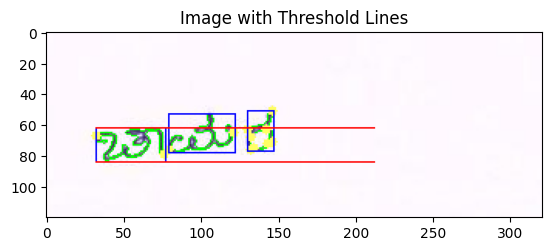

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load your image (replace 'your_image.jpg' with the actual path)
# image = master_img_copy.copy()
image = inputCopy.copy()

# Get the values from the first bounding box
x1, y1, w1, h1 = boundRect[0]
l = int(1.5 * len(boundRect))

# # # Get the values from the bounding box with the lowest x value
# min_x_rect = min(boundRect, key=lambda rect: rect[0])
# x1, y1, w1, h1 = min_x_rect

# Calculate the starting and ending points for a horizontal line
start_point1 = (x1, y1)
end_point1 = (x1 + (w1*l), y1)

start_point2 = (x1, y1+h1)
end_point2 = (x1 + (w1*l), y1+h1)

# Draw a horizontal line on the image
cv2.line(image, start_point1, end_point1, red , 1)
cv2.line(image, start_point2, end_point2, red , 1)

# Convert BGR image to RGB (OpenCV uses BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with the horizontal line
plt.imshow(image_rgb)
plt.title('Image with Threshold Lines')
plt.show()

In [ ]:
# Calculate word width and height - By using last and first bounding box's width and height
word_width = boundRect[-1][0] - boundRect[0][0]
word_height = boundRect[-1][1] - boundRect[0][1]

# Calculate character widths and heights - By using bounding box's width and height data itself
char_widths = [rect[2] for rect in boundRect]
char_heights = [rect[3] for rect in boundRect]

# Calculate character gaps for all characters by using difference between vertical last line of first character and first vertical bounding box line of second character
char_gaps = [abs((boundRect[i][0] + boundRect[i][2]) - boundRect[i+1][0]) for i in range(len(boundRect)-1)]
# Fill the first row of character gaps
char_gaps = char_gaps + [char_gaps[-1]]

# Calculate the skewed angle by plotting the most possible way of drawing a straight line that touches maximum top points from each character
# Calculate the skewed angle
# Assuming characters are aligned horizontally, find the angle that connects top points
top_points = [(rect[0] + rect[2] // 2, rect[1]) for rect in boundRect]
vx, vy, _, _ = cv2.fitLine(np.array(top_points), cv2.DIST_L2, 0, 0.01, 0.01)

# Calculate the angle from the horizontal axis
skewed_angle = np.arctan2(vy, vx) * 180 / np.pi

# Create a DataFrame for feature extraction
data = {'SI.No': list(range(len(boundRect))),
        'Character': [f'Char_{i+1}' for i in range(len(boundRect))],
        'Bounding Box': boundRect,
        'Character Width': char_widths,
        'Character Height': char_heights,
        'Character Gaps': char_gaps,
        'Word Width': [word_width] * len(boundRect),
        'Word Height': [word_height] * len(boundRect),
        'Skewed Angle': [skewed_angle] * len(boundRect)}

df = pd.DataFrame(data)

# Display the table
print(" Feature Extraction Table :")
print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))

# Print calculated values
print("\nBounding Boxes    : " , boundRect)
print("Word Width        : " , word_width)
print("Word Height       : " , word_height)
print("Character Widths  : " , char_widths)
print("Character Heights : " , char_heights)
print("Character Gaps    : " , char_gaps)
print("Skewed Angle      : " , skewed_angle)

file_path = '/content/drive/MyDrive/your_file_name.csv'

# Save DataFrame to CSV
df.to_csv(file_path, index=False)

df= pd.read_csv('/content/drive/MyDrive/your_file_name.csv')
df.head()

 Feature Extraction Table :
+-------+-----------+-------------------+-----------------+------------------+----------------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Character Width | Character Height | Character Gaps | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-----------------+------------------+----------------+------------+-------------+--------------+
|   0   |  Char_1   | (32, 62, 45, 22)  |       45        |        22        |       2        |     98     |     -11     | [-7.599144]  |
|   1   |  Char_2   | (79, 53, 43, 25)  |       43        |        25        |       8        |     98     |     -11     | [-7.599144]  |
|   2   |  Char_3   | (130, 51, 17, 26) |       17        |        26        |       8        |     98     |     -11     | [-7.599144]  |
+-------+-----------+-------------------+-----------------+------------------+----------------+------------+-------------+--------------+

Bound

,SI.No,Character,Bounding Box,Character Width,Character Height,Character Gaps,Word Width,Word Height,Skewed Angle
0,0,Char_1,"(32, 62, 45, 22)",45,22,2,98,-11,[-7.599144]
1,1,Char_2,"(79, 53, 43, 25)",43,25,8,98,-11,[-7.599144]
2,2,Char_3,"(130, 51, 17, 26)",17,26,8,98,-11,[-7.599144]


In [ ]:
#using custom csv dataframe
df= pd.read_csv('/content/final_output.csv')
df.head(10)

,SI.No,Datasheet,Pressure,Cell/ Word,Character,Bounding Box,Char_Width,Char_Height,Character Gaps,Word Width,Word Height,Skewed Angle
0,1,Scan_l,0,cell_1,Char_1,"(64, 40, 64, 48)",64,48,8,120,112,[-6.709837]
1,2,Scan_l,0,cell_1,Char_2,"(136, 32, 56, 64)",56,64,8,120,112,[-6.709837]
2,3,Scan_l,0,cell_10,Char_1,"(64, 48, 96, 64)",96,64,0,96,64,[0.]
3,4,Scan_l,0,cell_17,Char_1,"(59, 54, 45, 50)",45,50,8,93,111,[-11.309932]
4,5,Scan_l,0,cell_17,Char_2,"(112, 43, 48, 61)",48,61,8,93,111,[-11.309932]
5,6,Scan_l,0,cell_21,Char_1,"(72, 56, 96, 56)",96,56,0,96,56,[0.]
6,7,Scan_l,0,cell_9,Char_1,"(72, 40, 120, 56)",120,56,17,135,68,[-8.130102]
7,8,Scan_l,0,cell_9,Char_2,"(209, 28, 15, 12)",15,12,17,135,68,[-8.130102]
8,9,Scan_l,0,cell_13,Char_1,"(88, 48, 56, 48)",56,48,8,112,104,[-14.036244]
9,10,Scan_l,0,cell_13,Char_2,"(152, 32, 56, 56)",56,56,8,112,104,[-14.036244]


In [ ]:
!pip install timm
#connect to T4 GPU ONLY


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random

import os
import cv2
from PIL import Image

from tqdm import tqdm
import albumentations as A
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
# import timm
import torch
import torch.nn as nn
import torch.optim as optim


import sys
import pathlib
import numpy as np
import pandas as pd
from keras.layers import Dense, Conv2D, Flatten
from sklearn.utils import shuffle
from keras.optimizers import Adam
from skimage.filters import sobel
from keras.utils import to_categorical
from skimage.segmentation import watershed
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from glob import glob
from google.colab import drive
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda'


In [ ]:
df.shape

(1409, 12)

In [ ]:
df.Pressure.value_counts()

Pressure
1    523
0    500
2    386
Name: count, dtype: int64

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from joblib import dump

# Load the data
data = pd.read_csv('/content/final_output.csv')

# Separate features and target variable
X = data.drop('Pressure', axis=1)  # Features
y = data['Pressure']  # Target variable

# Map ClassId to binary labels (1 for abnormal, 0 for normal)
y_binary = y.apply(lambda x: 1 if x != 0 else 0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=70, random_state=42, max_depth=None)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Predicted Accuracy: ", accuracy*100)

dump(clf, 'random_forest_model.joblib')

Predicted Accuracy:  68.08510638297872


['random_forest_model.joblib']

In [ ]:
from joblib import load
import pandas as pd

# Load the saved model
clf = load('/content/random_forest_model.joblib')

# Load your own dataset
new_data = pd.read_csv('/content/image_features.txt')

# Assuming 'X_new' contains the features of your dataset
X_new = new_data.drop('ClassId', axis=1)  # Assuming 'ClassId' is the target variable

# Make predictions on the new dataset
predictions = clf.predict(X_new)

from sklearn.metrics import accuracy_score

# Assuming 'y_true' contains the ground truth labels
y_true = new_data['ClassId']  # Assuming 'ClassId' is the target variable

# Calculate accuracy
accuracy = accuracy_score(y_true, predictions)
print(f"Validation Accuracy: {accuracy:.2f}")

print(predictions)

predictions_labels = ['normal' if pred == 0 else 'abnormal' for pred in predictions]

predictions_array = np.array(predictions_labels)

print(predictions_array)

Validation Accuracy: 0.67
[0 0 0 ... 1 1 1]
['normal' 'normal' 'normal' ... 'abnormal' 'abnormal' 'abnormal']


In [ ]:
## CNN model

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # if idx >= 12:
        #   # return None
        #   # return torch.zeros(3, 1, 1), 0, torch.zeros(1, 4)
        #   # Return placeholder values for empty samples with the same size as actual images
        #   # placeholder_img = torch.zeros(3, 112, 112)
        #   # return placeholder_img, 0, torch.zeros(1, 4)
        #     # Return placeholder values for empty samples
        #   placeholder_img = torch.zeros(3, 112, 112)
        #   return placeholder_img, 0, torch.zeros(4)  # Adjust the size of the bounding box tensor

        #get img
        # img_path = '/content/cropped_cells/cell_' + str(idx) + '.jpg'
        # print("Image path:", img_path)  # Add this print statement
        # img = Image.open(img_path).convert('RGB')



        #get bbox
        row = self.dataframe.iloc[idx]
        xmin, ymin, width, height = map(float, row['Bounding Box'].strip('()').split(','))  # Convert string to integer
        print(xmin, ymin, width, height)

        xmax = xmin + width
        ymax = ymin + height

        # Normalize the bounding box coordinates
        # Get image dimensions
        img_width, img_height = img.size

        # Normalize the bounding box coordinates
        xmin_norm = float(xmin / img_width)
        ymin_norm = float(ymin / img_height)
        xmax_norm = float(xmax / img_width)
        ymax_norm = float(ymax / img_height)

        bbox = [[xmin_norm, ymin_norm, xmax_norm, ymax_norm]]
        # bbox = [[xmin, ymin,width, height]]


        print("Bounding box:", bbox)

        class_id = self.dataframe.iloc[idx]['ClassId']

        if self.transform:
            augmented = self.transform(image=np.array(img), bboxes=bbox, ClassId=[class_id])
            img = augmented['image']
            bbox = augmented['bboxes'][0]
            class_id = augmented['ClassId'][0]

        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0 # (h, w, c) -> (c, h, w)
        bbox = torch.Tensor(bbox)

        return img, class_id, bbox

In [ ]:
train_augs = A.Compose([
    A.Resize(112, 112),
], bbox_params=A.BboxParams(format='coco', label_fields=['ClassId']))

val_augs = A.Compose([
    A.Resize(112, 112),
], bbox_params=A.BboxParams(format='coco', label_fields=['ClassId']))

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train = CustomDataset(train_df, train_augs)
val = CustomDataset(val_df, val_augs)

len(train), len(val)

(1127, 282)

In [ ]:
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=32)

# train_loader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val, batch_size=4)
## batch size set as 4



In [ ]:
img, class_id, bbox = val[0]

xmin, ymin, width, height = bbox
xmax = xmin + width
ymax = ymin + height

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

if isinstance(img, torch.Tensor):
    img = img.permute(1, 2, 0).numpy()
else:
    img = img

bnd_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 1)
# plt.imshow(bnd_img)
# plt.title('Class: '+ str(class_id));

In [ ]:
class ClassificationNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
        )

        self.layer6 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 1000),
            nn.ReLU(inplace=True),
        )

        self.layer7 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=256),
            nn.ReLU(inplace=True),
        )

        self.layer8 = nn.Sequential(
            nn.Linear(256, 43)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = x.view(x.shape[0], -1)

        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)

        return x

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()

        self.bbox_regression_branch = timm.create_model('efficientnet_b0', pretrained=True, num_classes=4)

        self.classification_branch = ClassificationNet()


    def forward(self, images):

        classification_output = self.classification_branch(images)

        bbox_output = self.bbox_regression_branch(images)

        return classification_output, bbox_output

In [ ]:
model = CombinedModel().to(device)


In [ ]:
classification_loss = nn.CrossEntropyLoss()
bbox_loss = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# init loss to compare and save best model later
best_val_loss = float('inf')
best_model_weights = None

epochs = 15
for epoch in range(1, epochs + 1):

    # training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    train_loader_with_progress = tqdm(train_loader, desc=f'[TRAIN] Epoch {epoch}/{epochs}')

    for images, labels, bboxes in train_loader_with_progress:
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)
        classification_output, bbox_output = model(images)

        classification_loss_value = classification_loss(classification_output, labels)
        bbox_loss_value = bbox_loss(bbox_output, bboxes)
        total_loss = classification_loss_value + bbox_loss_value

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()
        _, predicted = torch.max(classification_output.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        accuracy_train = correct_train / total_train

        postfix_dict = {'classification loss': classification_loss_value.item(), 'bbox loss': bbox_loss_value.item(), 'classification acc': accuracy_train }
        train_loader_with_progress.set_postfix(postfix_dict)

    print(f'Train Epoch {epoch}/{epochs}:')
    print(f'Train Loss: {train_loss / len(train_loader):.4f}')
    print(f'Train Accuracy: {accuracy_train * 100:.2f}%')


    # validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    val_loader_with_progress = tqdm(val_loader, desc=f'[VALID] Epoch {epoch}/{epochs}')

    with torch.no_grad():
        for images, labels, bboxes in val_loader_with_progress:
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)

            classification_output, bbox_output = model(images)

            classification_loss_value = classification_loss(classification_output, labels)
            bbox_loss_value = bbox_loss(bbox_output, bboxes)

            total_loss = classification_loss_value + bbox_loss_value

            val_loss += total_loss.item()
            _, predicted = torch.max(classification_output.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            accuracy_val = correct_val / total_val

            postfix_dict2 = {'classification loss': classification_loss_value.item(), 'bbox loss': bbox_loss_value.item(), 'classification acc': accuracy_val }
            val_loader_with_progress.set_postfix(postfix_dict2)

    # val_loss /= len(val_loader)
    print(f'Validation Epoch {epoch}/{epochs}:')
    # print(f'Validation Loss by me: {val_loss / len(val_loader):.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation Accuracy: {accuracy_val*100:.2f}%')


    # save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()

torch.save(best_model_weights, 'best_model_weights.pt')

In [ ]:
model = CombinedModel().to(device);

model.load_state_dict(torch.load('/content/best_model_weights.pt'))

model.eval()

In [ ]:
def display_image(image_tensor, classification_output, bbox_output, actual_class, actual_bbox):

    image = np.array(image_tensor.cpu())
    image = np.transpose(image, (1, 2, 0))  # (c, h, w) -> (h, w, c)

    classification_output = classification_output.cpu().squeeze().numpy()
    bbox_output = bbox_output.cpu().squeeze().numpy()
    actual_bbox = actual_bbox.cpu().squeeze().numpy()
    plt.imshow(image)
    plt.axis('off')

    predicted_bbox = plt.Rectangle((bbox_output[0],
                                    bbox_output[1]),
                                    bbox_output[2] - bbox_output[0],
                                    bbox_output[3] - bbox_output[1],
                                    linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(predicted_bbox)

    actual_bbox_rect = plt.Rectangle((actual_bbox[0],
                                      actual_bbox[1]),
                                      actual_bbox[2] - actual_bbox[0],
                                      actual_bbox[3] - actual_bbox[1],
                                      linewidth=2, edgecolor='g', facecolor='none')
    plt.gca().add_patch(actual_bbox_rect)

    plt.title(f'Predicted: {np.argmax(classification_output)}', color='red', loc='left')
    plt.title(f' Actual: {actual_class}', color='green', loc='right')

    plt.show()

In [ ]:
num_samples = len(val_loader.dataset)
random_indices = random.sample(range(num_samples), 10) # show X amount of random pics

for idx, (images, labels, bboxes) in enumerate(val_loader):
    if idx in random_indices:
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)

        with torch.no_grad():
            classification_output, bbox_output = model(images)

        for i in range(len(images)):
            image = images[i]
            actual_class = labels[i]
            actual_bbox = bboxes[i]

            display_image(image, classification_output[i], bbox_output[i], actual_class, actual_bbox)

Image path: /content/cropped_cells/cell_0.jpg
48.0 41.0 88.0 47.0
Bounding box: [[0.15047021943573669, 0.3445378151260504, 0.4263322884012539, 0.7394957983193278]]
Image path: /content/cropped_cells/cell_1.jpg
104.0 40.0 96.0 48.0
Bounding box: [[0.32298136645962733, 0.3333333333333333, 0.6211180124223602, 0.7333333333333333]]
Image path: /content/cropped_cells/cell_2.jpg
24.0 32.0 56.0 48.0
Bounding box: [[0.07547169811320754, 0.2689075630252101, 0.25157232704402516, 0.6722689075630253]]
Image path: /content/cropped_cells/cell_3.jpg
74.0 40.0 38.0 37.0
Bounding box: [[0.23197492163009403, 0.3333333333333333, 0.3510971786833856, 0.6416666666666667]]
Image path: /content/cropped_cells/cell_4.jpg
176.0 103.0 39.0 32.0
Bounding box: [[0.5569620253164557, 0.8956521739130435, 0.680379746835443, 1.173913043478261]]
Image path: /content/cropped_cells/cell_5.jpg
128.0 48.0 24.0 32.0
Bounding box: [[0.4, 0.40336134453781514, 0.475, 0.6722689075630253]]
Image path: /content/cropped_cells/cell_6.

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
train_path = "/content/drive/MyDrive/ProcessedData/Train"

In [ ]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
for layer in inception.layers:
  layer.trainable = False

In [ ]:
folders = glob('/content/drive/MyDrive/ProcessedData/Train/*')

In [ ]:
len(folders)

2

In [ ]:
x = Flatten()(inception.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset

train_datagen = ImageDataGenerator(rescale = 1/255,
                                   shear_range = 0.3,
                                   zoom_range = 0.4,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
##no need to apply the above data aug steps in test_set, applied in training to populate the set

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/ProcessedData/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 379 images belonging to 2 classes.


In [ ]:
# Make sure you provide the same target size as initialied for the image size
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/ProcessedData/Test',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 136 images belonging to 2 classes.


In [ ]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
24/24 [==============================] - 252s 10s/step - loss: 2.3081 - accuracy: 0.6702 - val_loss: 1.4823 - val_accuracy: 0.6397
Epoch 2/10
24/24 [==============================] - 72s 3s/step - loss: 1.4913 - accuracy: 0.7493 - val_loss: 5.2729 - val_accuracy: 0.5000
Epoch 3/10
24/24 [==============================] - 71s 3s/step - loss: 1.3225 - accuracy: 0.7520 - val_loss: 2.8260 - val_accuracy: 0.5882
Epoch 4/10
24/24 [==============================] - 71s 3s/step - loss: 0.8801 - accuracy: 0.8391 - val_loss: 2.6651 - val_accuracy: 0.6176
Epoch 5/10
24/24 [==============================] - 73s 3s/step - loss: 0.7831 - accuracy: 0.8206 - val_loss: 4.0591 - val_accuracy: 0.5515
Epoch 6/10
24/24 [==============================] - 68s 3s/step - loss: 1.1092 - accuracy: 0.8206 - val_loss: 2.7748 - val_accuracy: 0.7500
Epoch 7/10
24/24 [==============================] - 67s 3s/step - loss: 0.9076 - accuracy: 0.8391 - val_loss: 2.5539 - val_accuracy: 0.6912
Epoch 8/10
24/24 [